# Question 1

### Value Iteration Setup

In [1]:
# importing dependencies

import gym
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
# function for value iteration

def value_iteration(env, gamma, eps = 1e-12):
    elapsed = time.time()
    num_states = env.nS
    transition = env.env.P
    value_function = np.zeros(num_states)
    num_iterations = 0
    
    delta = float('inf')
    while (delta >= eps):
        num_iterations += 1
        delta = 0
        for state in range(num_states):
            prev_value = value_function[state]
            for action in transition[state]:
                updated_value = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    updated_value += prob * (reward + gamma * value_function[next_state])
                value_function[state] = max(value_function[state], updated_value)
            delta = max(delta, abs(value_function[state] - prev_value))
    
    policy = np.zeros(num_states)
    for state in range(num_states):
        val = float('-inf')
        for action in transition[state]:
            return_val = 0
            for prob, next_state, reward, is_terminal in transition[state][action]:
                    return_val += prob * (reward + gamma * value_function[next_state])
            if (return_val > val):
                val = return_val
                policy[state] = action
    elapsed = time.time() - elapsed
    return value_function, policy, num_iterations, elapsed

### Value Iteration on Frozen Lake environment and storing results

In [3]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('FrozenLake8x8-v0')
results_fl = {}
start_fl = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = value_iteration(env, gamma)
    results_fl[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Value Iteration on Taxi environment and storing results

In [4]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('Taxi-v3')
results_taxi = {}
start_taxi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = value_iteration(env, gamma)
    results_taxi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}



### Functions to display results

In [5]:
def print_result_FrozenLake(results, gamma):
    
    print(f'\ngamma: {gamma}\n')
    
    value_function = results[gamma]['value_function']
    policy = results[gamma]['policy']
    num_iterations = results[gamma]['num_iterations']
    
    
    print("Value Function:")
    for i in range(8):
        for j in range(8):
            print(format(value_function[8*i+j], '.2f'), end = ' ')
        print()
    print()
    
    print("Policy:")
    mapping = {0: 'L', 1: 'U', 2: 'R', 3: 'D'}
    for i in range(8):
        for j in range(8):
            print(f' {mapping[policy[8*i+j]]}  ', end = ' ')
        print()
    print()
    
    print(f'Number of Iterations: {num_iterations}')
    print('-------------------------------------------------------------')

In [6]:
def plot_gamma_iterations(**kwargs):
    
    num_plots = len(kwargs)
    fig, axs = plt.subplots(1, num_plots+1)
    plot_cnt = 0
    
    for label in kwargs:
        results = kwargs[label]
        x, y = [], []
        for gamma in results:
            x.append(gamma)
            y.append(results[gamma]['num_iterations'])
        axs[plot_cnt].plot(x, y, label = label)
        axs[plot_cnt].set_title(label)
        axs[plot_cnt].legend()
        plot_cnt += 1
        if (num_plots > 1):
            axs[num_plots].plot(x, y, label = label)
    if (num_plots > 1):
        axs[num_plots].set_title("Combined")
        axs[num_plots].legend()
    fig.tight_layout()

In [7]:
def plot_gamma_value(**kwargs):
    
    num_plots = len(kwargs)
    fig, axs = plt.subplots(1, num_plots+1)
    plot_cnt = 0
    
    for label in kwargs:
        results, start = kwargs[label]
        x, y = [], []
        for gamma in results:
            x.append(gamma)
            #y.append(results[gamma]['value_function'][start])
            y.append(max(results[gamma]['value_function']))
        axs[plot_cnt].plot(x, y, label = label)
        axs[plot_cnt].set_title(label)
        axs[plot_cnt].legend()
        plot_cnt += 1
        if (num_plots > 1):
            axs[num_plots].plot(x, y, label = label)
    if (num_plots > 1):
        axs[num_plots].set_title("Combined")
        axs[num_plots].legend()
    fig.tight_layout()

### Number of Iterations v/s Gamma Plot

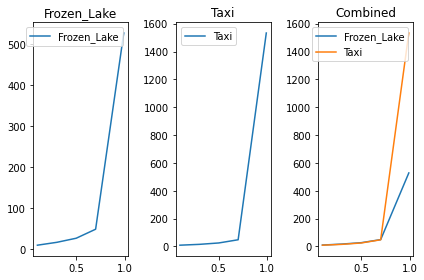

In [8]:
plot_gamma_iterations(Frozen_Lake = results_fl, Taxi = results_taxi)

### State Value of start state v/s Gamma Plot
```
y-axis has:
max norm of value function in case of taxi
value function of start state (0) in case of frozen_lake
```

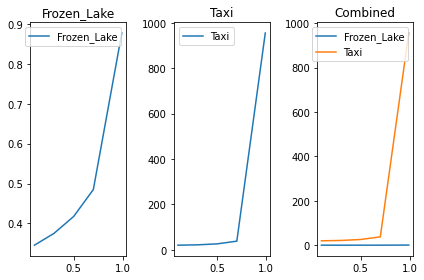

In [9]:
plot_gamma_value(Frozen_Lake = (results_fl, start_fl), Taxi = (results_taxi, start_taxi))

### Observations


# Question 2

### Policy Iteration Setup

In [10]:
# function for policy iteration

def policy_iteration(env, gamma, eps = 1e-12):
    elapsed = time.time()
    num_states = env.nS
    transition = env.env.P    
    
    policy = [np.random.choice(list(transition[state].keys())) for state in range(num_states)]
    value_function = np.zeros(num_states)#
    
    def policy_evaluation():
        #value_function = np.zeros(num_states)
        num_iterations = 0
        
        while (True):
            num_iterations += 1
            delta = float('-inf')
            #value_function_ = np.zeros(num_states)

            for state in range(num_states):
                prev_value = value_function[state]#
                action = policy[state]
                updated_value = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    updated_value += prob * (reward + gamma * value_function[next_state])
                #value_function_[state] = max(value_function[state], updated_value)
                #delta = max(delta, abs(value_function_[state] - value_function[state]))
                value_function[state] = max(value_function[state], updated_value)#
                delta = max(delta, abs(value_function[state] - prev_value))#
                   
            #value_function = value_function_.copy()
            if (delta < eps):
                break
        return value_function, num_iterations
    
    def policy_improvement(value_function):
        has_converged = True
        for state in range(num_states):
            prev_action = policy[state]
            max_return = float('-inf')
            best_action = -1
            for action in transition[state]:
                returns = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    returns += prob * (reward + gamma * value_function[next_state])
                if (returns > max_return or (returns == max_return and action == prev_action)):
                    max_return, best_action = returns, action
            if (best_action != prev_action):
                has_converged = False
            
            policy[state] = best_action
        return has_converged
    
    num_iterations = 0
    while (True):
        value_function, iterations = policy_evaluation()
        num_iterations += iterations
        has_converged = policy_improvement(value_function)
        if (has_converged):
            break
    
    elapsed = time.time() - elapsed
    return value_function, policy, num_iterations, elapsed
    

### Policy Iteration on Frozen Lake environment and storing results

In [11]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('FrozenLake8x8-v0')
results_fl = {}
start_fl = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = policy_iteration(env, gamma)
    results_fl[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Policy Iteration on Taxi environment and storing results

In [12]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('Taxi-v3')
results_taxi = {}
start_taxi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = policy_iteration(env, gamma)
    results_taxi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Number of Iterations v/s Gamma Plot

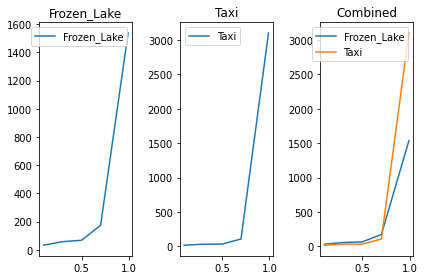

In [13]:
plot_gamma_iterations(Frozen_Lake = results_fl, Taxi = results_taxi)

### Value of start state v/s Gamma Plot
```
y-axis has:
max norm of value function in case of taxi
value function of start state (0) in case of frozen_lake
```

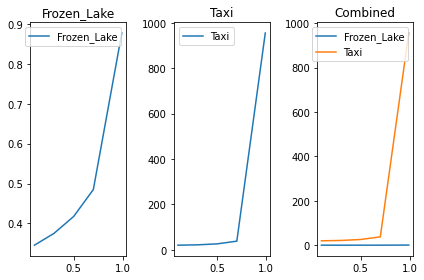

In [14]:
plot_gamma_value(Frozen_Lake = (results_fl, start_fl), Taxi = (results_taxi, start_taxi))

### Observations

# Question 3

*Value Iteration* uses **less number of iterations** than *Policy Iteration* but is overall **slower (takes more time)** as it involves argmax over all possible actions in each state which makes every iteration of *Value Iteration* more expensive as compared to that of *policy iteration*.

Following are the statistics for the number of iterations taken:
*(for epsilon = 1e-12)*

| | Number of Iterations | |
| :-: | :-: | :-: |
| Environment | Value Iteration | Policy Iteration |
| Frozen_Lake | 500 | 1600 |
| Taxi | 1600 | 3000 |


| | Time taken | |
| :-: | :-: | :-: |
| Environment | Value Iteration | Policy Iteration |
| Frozen_Lake | 0.49 | 0.45 |
| Taxi | 10 | 5 |

The reason as to why value iteration takes less number of iterations is:
It combines the policy evaluation and policy improvement step by making updates to the value function directly, hence the faster convergence.

The reason as to why value iteration still takes more time is:
It involves argmax over all possible actions in each state which makes every iteration of *Value Iteration* more expensive as compared to that of *Policy Iteration* and hence greater execution time.
